<a href="https://colab.research.google.com/github/ahariri13/ML4SCI/blob/main/HiggsBosonClassificationChallenge/higgs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



**Dataset:** The dataset is made available by the Center for Machine Learning and Intelligent Systems at University of California, Irvine. 
The dataset can be found on the [UCI Machine learning Repository](https://archive.ics.uci.edu/ml/datasets/HIGGS)

**This is an example Notebook for running training on Higgs vs background signal classification. **

**Background:** High-energy collisions at the Large Hadron Collider (LHC) produce particles that interact with particle detectors. One important task is to classify different types of collisions based on their physics content, allowing physicists to find patterns in the data and to potentially unravel new discoveries. 

**Problem statement:** The discovery of the Higgs boson by CMS and ATLAS Collaborations was announced at CERN in 2012. In this work, we focus on the potential of Machine Learning and Deep Learning in detecting potential Higgs signal from one of the background processes that mimics it. 

**Description:** The dataset consists of a total of 11 million labeled samples of Higgs vs background events produced by Monte Carlo simulations. Each sample consists of 28 features. The first 21 features are kinematic properties measured at the level of the detectors. The last seven are functions of the first 21.




**Imports first**

We need to install shap everytime we reconnect to the notebook because it is not installed on google machines by default. The rest of the notebook's dependencies are.

Starting a line of code with an exclamation point causes it to be executed as a shell (UNIX) command.

In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 26.5 MB/s eta 0:00:00


In [36]:
import pandas as pd
import numpy as np
import xgboost
import matplotlib.pyplot as plt
import shap
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn import metrics

**Two ways to import data**

**Trust Me method**

The data is provided for you in the google drive directory. It is convenient to store data locally when you'll be using it repeatedly. However the colab notebook is running on a google machine and cannot access your google drive by default. To access the data directly from your drive we will mount it.

However, once you mount your drive it is accessible from the google machine until the runtime is unassigned. Thus the notebook can access any file on your drive and could potentially cause problems (delete) if you run nefarious code while the drive is mounted.

It is safe to run this notebook with the drive mounted. It is of course also safe to run code that you have written because you know what it does. But generally it is NOT SAFE to run unknown code in places where it can damage your files.

Note that mounting the drive will require an authorization prompt.

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
data = pd.read_parquet('drive/My Drive/PURSUE_ML/HIGGS.parquet')

**Download dataset new**

This method is safer in that you do not need to mount your drive--however it will require you to redownload the data set each time you reconnect to the notebook. The next two steps can take a few minutes.

1. Download the dataset from the UCI website. 

In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2023-06-06 21:01:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  18.9MB/s    in 2m 23s  

2023-06-06 21:03:57 (18.7 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



2. Unzip the dataset folder

In [4]:
!gzip -d HIGGS.csv.gz

In [5]:
!ls -lh

total 7.5G
-rw-r--r-- 1 root root 7.5G Feb 14  2014 HIGGS.csv
drwxr-xr-x 1 root root 4.0K Jun  5 16:31 sample_data


You can see that the csv file is now stored locally on the google machine. But when you disconnect from the runtime it will be deleted (so someone else can use the machine) and you will need to redownload it next time you connect.

Load the file using pandas library

In [6]:
data=pd.read_csv('./HIGGS.csv', nrows=100000)

We are going to be XGBoost for our BDT. We will run into memory issues on Colab and will take only 100K events

**Start Selecting Data**

In [19]:
X = data.iloc[:100000,1:]
y = data.iloc[:100000,0]
#data_top = data.head()
data.columns =  ['Signal','lepton pT', 'lepton eta', 'lepton phi', 'E_miss', 'E_miss^phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta','jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag','m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
X.columns = ['lepton pT', 'lepton eta', 'lepton phi', 'E_miss', 'E_miss^phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag', 'jet 2 pt', 'jet 2 eta','jet 2 phi', 'jet 2 b-tag', 'jet 3 pt', 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta', 'jet 4 phi', 'jet 4 b-tag','m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
y.columns = ['Signal']
vlist = ['jet 4 b-tag','jet 3 b-tag','jet 2 b-tag','jet 1 pt','m_jjj','m_bb','m_wwbb','E_miss','jet 1 phi','lepton phi']

In [20]:
print(sum(y))

52833.0


### Question
What does sum(y) tell us and why is it important?

In [21]:
X = X[vlist]

In [22]:
X.columns

Index(['jet 4 b-tag', 'jet 3 b-tag', 'jet 2 b-tag', 'jet 1 pt', 'm_jjj',
       'm_bb', 'm_wwbb', 'E_miss', 'jet 1 phi', 'lepton phi'],
      dtype='object')

Split data set into test, validate and train sets. Using random state selects the same events each run for consistency.

In [23]:
X_train, X_validate, X_test = np.split(X.sample(frac=1, random_state=42), [int(.6*len(X)), int(.8*len(X))])
y_train, y_validate, y_test = np.split(y.sample(frac=1, random_state=42), [int(.6*len(y)), int(.8*len(y))])

In [11]:
d_train = xgboost.DMatrix(X_train, label=y_train, feature_names=X.columns[:])
d_test = xgboost.DMatrix(X_test, label=y_test, feature_names=X.columns[:])
d_validate = xgboost.DMatrix(X_validate, label=y_validate, feature_names=X.columns[:])


**Visualize your data - One histogram per feature column**

Detailed information on what each feature column is can be found in *Attribute Information* section on the [UCI Machine learning Repositery](https://archive.ics.uci.edu/ml/datasets/HIGGS). For further information, refer to the [paper](https://www.nature.com/articles/ncomms5308) by Baldi et. al 

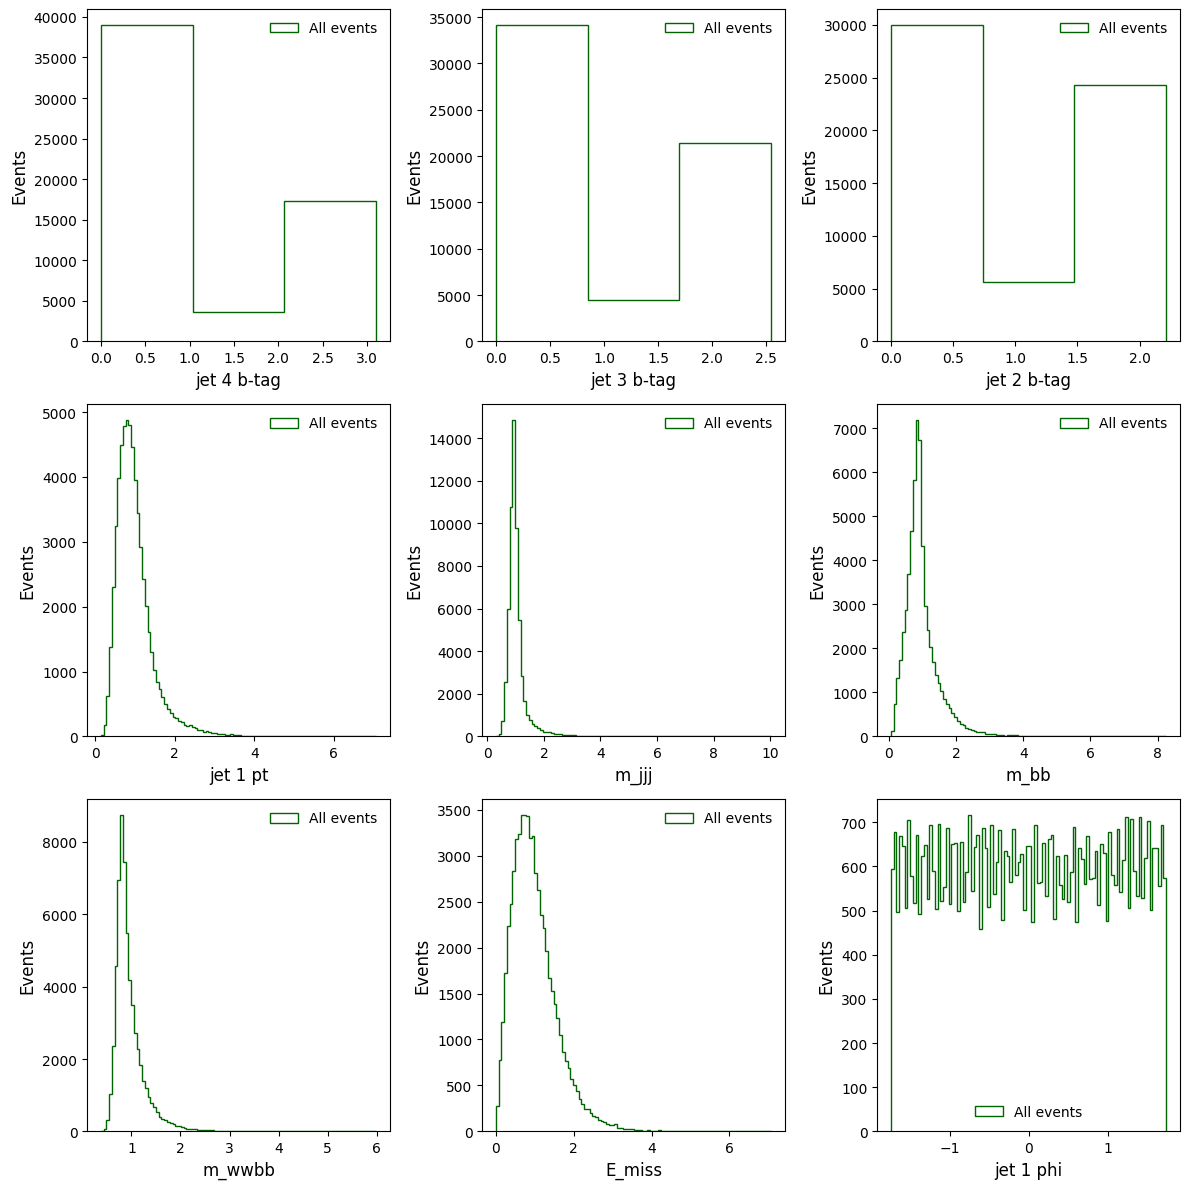

In [12]:
fig = plt.figure(figsize=(12, 12))

#for i in range(len(X_train.columns)-1):
for i in range(len(vlist)-1):
    #col = X_train.columns[i]
    col = vlist[i]
    nbins =100
    if 'b-tag' in col: nbins = 3
    axis = fig.add_subplot(3,3,i+1)
    X_train[col].hist(bins=nbins, ax=axis, histtype='step', color='darkgreen', label='All events')
    axis.grid(False)
    plt.xlabel(col,fontsize=12)
    plt.ylabel('Events',fontsize=12)
    plt.legend(frameon=False) 

fig.tight_layout() 
plt.show()

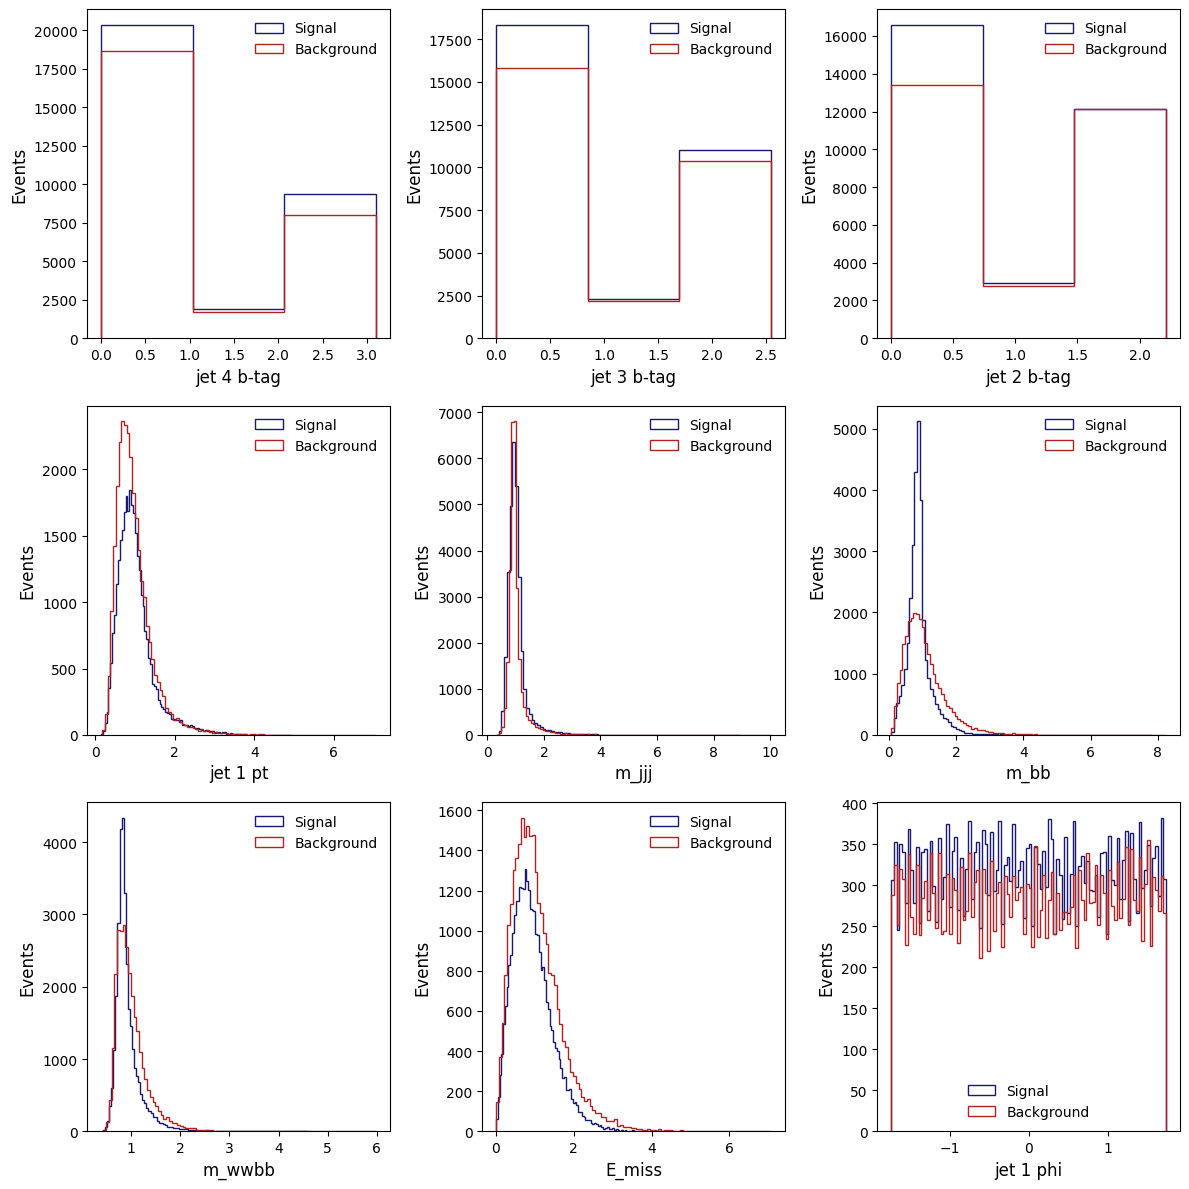

In [13]:
fig = plt.figure(figsize=(12, 12))

#for i in range(len(X_train.columns)-1):
for i in range(len(vlist)-1):
    #col = X_train.columns[i]
    col = vlist[i]
    nbins =100
    if 'b-tag' in col: nbins = 3
    axis = fig.add_subplot(3,3,i+1)
    X_train[col][d_train.get_label().astype('bool')].hist(bins=nbins, ax=axis, histtype='step', color='midnightblue', label='Signal')
    X_train[col][~(d_train.get_label().astype('bool'))].hist(bins=nbins, ax=axis, histtype='step', color='firebrick', label='Background')
    axis.grid(False)
    plt.xlabel(col,fontsize=12)
    plt.ylabel('Events',fontsize=12)
    plt.legend(frameon=False) 
    i = i+1

fig.tight_layout() 
plt.show()

### Question

Can you tell which variables will be most useful for identification?

**Setup the Boosted Decision Tree model** (BDT explanation [here](https://docs.microsoft.com/en-us/azure/machine-learning/algorithm-module-reference/boosted-decision-tree-regression#:~:text=Boosting%20means%20that%20each%20tree,small%20risk%20of%20less%20coverage.))

In [23]:
params ={
    'max_depth':10,
    'eta': 0.005,
    'objective':'binary:logistic',
    'subsample':0.8,
    'colsample_bytree':0.8,
    'base_score':np.mean(y_train),
    'eval_metric':'auc'
}

parameters = list(params.items()) + [('eval_metric', 'error')] + [('eval_metric', 'rmse')]

model = xgboost.train(parameters, d_train, num_boost_round=1000, evals = [(d_test, "test")], verbose_eval=100, early_stopping_rounds=10)

[0]	test-auc:0.71591	test-error:0.47110	test-rmse:0.49872
[100]	test-auc:0.74978	test-error:0.32545	test-rmse:0.47279
[200]	test-auc:0.75064	test-error:0.32345	test-rmse:0.46051
[300]	test-auc:0.75148	test-error:0.31960	test-rmse:0.45445
[400]	test-auc:0.75222	test-error:0.32040	test-rmse:0.45136
[500]	test-auc:0.75284	test-error:0.31980	test-rmse:0.44979
[600]	test-auc:0.75340	test-error:0.31815	test-rmse:0.44896
[700]	test-auc:0.75381	test-error:0.31820	test-rmse:0.44848
[800]	test-auc:0.75412	test-error:0.31835	test-rmse:0.44819
[900]	test-auc:0.75433	test-error:0.31855	test-rmse:0.44804
[911]	test-auc:0.75431	test-error:0.31875	test-rmse:0.44804


In [24]:
predictions = model.predict(d_test)

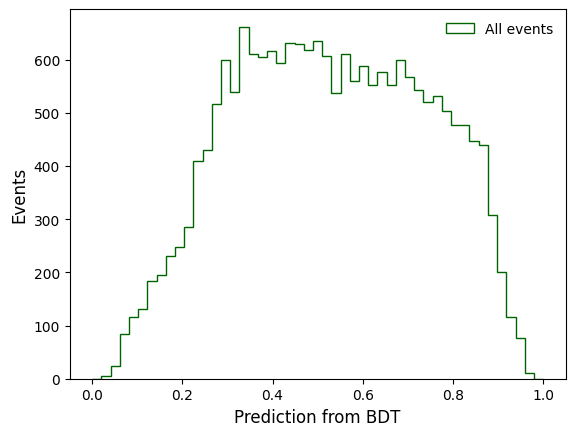

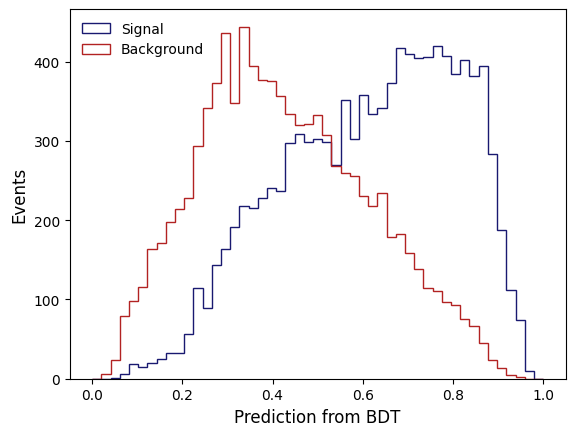

In [25]:
# plot all predictions (both signal and background)
plt.figure()
plt.hist(predictions,bins=np.linspace(0,1,50),histtype='step',color='darkgreen',label='All events')
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12)
plt.ylabel('Events',fontsize=12)
plt.legend(frameon=False)

# plot signal and background separately
plt.figure()
plt.hist(predictions[d_test.get_label().astype(bool)],bins=np.linspace(0,1,50),
         histtype='step',color='midnightblue',label='Signal')
plt.hist(predictions[~(d_test.get_label().astype(bool))],bins=np.linspace(0,1,50),
         histtype='step',color='firebrick',label='Background')
# make the plot readable
plt.xlabel('Prediction from BDT',fontsize=12)
plt.ylabel('Events',fontsize=12)
plt.legend(frameon=False)

### Question

What should the lower plot look like if the BDT performs very well? Or very poorly?

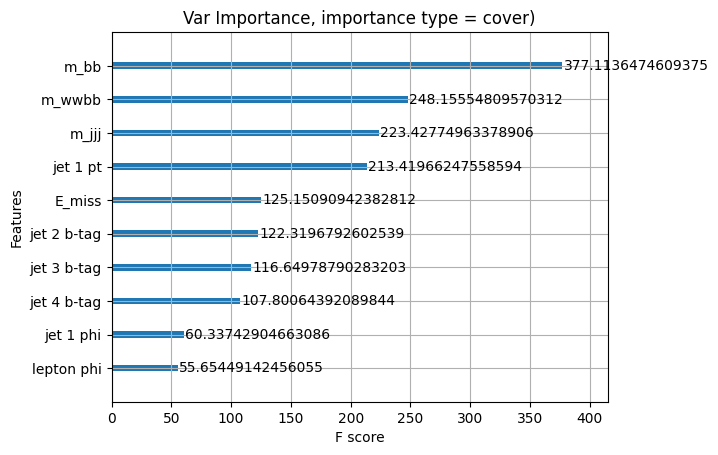

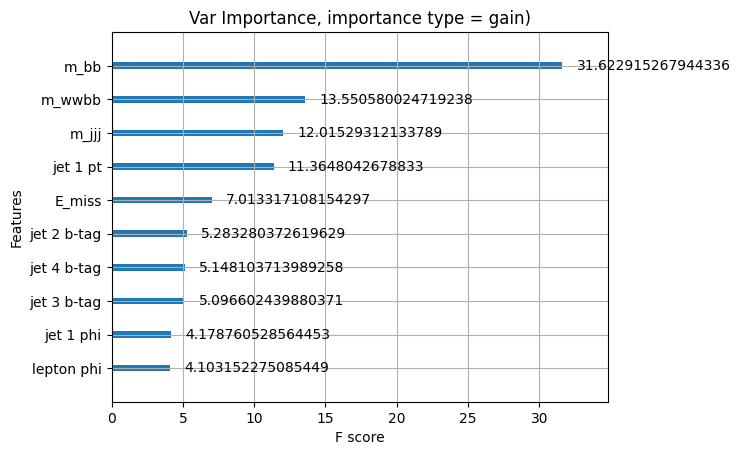

In [21]:
### Take a peak at the most important variables as decided by xgboost
xgboost.plot_importance(model, importance_type="cover")
plt.title("Var Importance, importance type = cover)")
plt.show()
xgboost.plot_importance(model, importance_type="gain")
plt.title("Var Importance, importance type = gain)")
plt.show()

### Question 

What is the difference between "cover" and "gain" when looking for variable importance? (Google)

**Use SHAP to take a close look as to how the model is using the variables to classify events**





(1000, 10)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


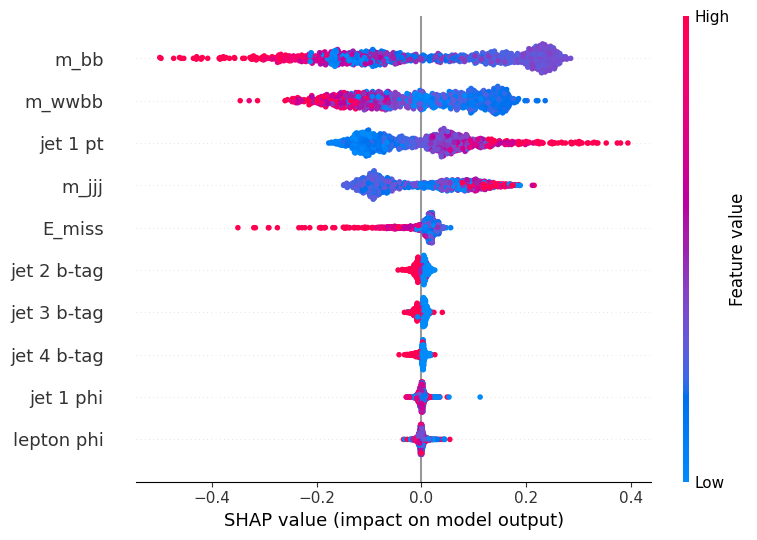

In [22]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train[:1000])
print(np.array(shap_values).shape)
#shap.force_plot(explainer.expected_value, shap_values[0,:],data.columns[1:],link = 'logit')
shap.summary_plot(shap_values,X_train[:1000],feature_names=X.columns) 
#shap.summary_plot(shap_values,data.columns[1:],plot_type='bar') 


### Question?

The above plots all tell us soething about how the input variables will effect the model. Take for example E_miss. We can see that if this value is high, it strongly dictates the SHAP value of the model negatively. (This means it drives it more to isSignal=0)

### Question

Do these results make sense when looking at the variables plotted above?


In [48]:
vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)),columns=['feature','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
feature_importance.reset_index(drop=True)

feature  feature_importance_vals
0         m_bb                 0.164914
1       m_wwbb                 0.102776
2     jet 1 pt                 0.086912
3        m_jjj                 0.082589
4       E_miss                 0.027621
5  jet 2 b-tag                 0.008607
6  jet 3 b-tag                 0.007329
7  jet 4 b-tag                 0.005564
8    jet 1 phi                 0.004485
9   lepton phi                 0.004459

Reorder vlist into order of importance (according to SHAP)

In [49]:
vlist = feature_importance['feature'].tolist()
print(vlist)

['m_bb', 'm_wwbb', 'jet 1 pt', 'm_jjj', 'E_miss', 'jet 2 b-tag', 'jet 3 b-tag', 'jet 4 b-tag', 'jet 1 phi', 'lepton phi']


### Question

Why would we be interested in the correlations between our input variables?

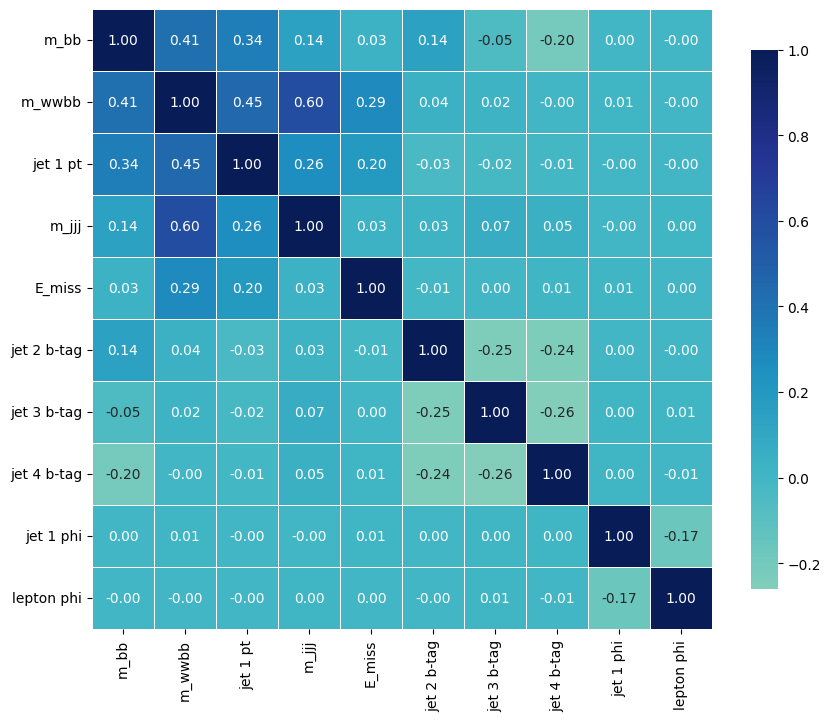

In [50]:
import seaborn as sns

correlations = X_train[vlist].corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
           square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
           )
plt.show()
  


In [51]:
correlatedVars= {}
correlation_cutoff = 0.45 #  ¯\_(ツ)_/¯ 
for c in X.columns[:]:  
  for r in X.columns[:]:
    if c!=r and correlations[r][c] > correlation_cutoff:
      #print (r,c,' Correlation  = '+str(correlations[r][c]))
      if c not in correlatedVars:
        correlatedVars[c] = 1
      else:
        correlatedVars[c] +=1
print(correlatedVars)  ### If a variable is in this dict, we will absolutely not remove it. This can be changed
print(str(len(correlatedVars))+'/'+ str(len(X.columns[:]))+' are classified as correlated')
  

{'m_jjj': 1, 'm_wwbb': 1}
2/10 are classified as correlated


You can try removing one of these variables to see if it affects your results.

### Hyperparameter optimization

Optimization on eta is shown here. You can also try adding other variables to see if performance can be improved.

In [ ]:
## VERY SLOW!!

import time
max_auc = 0
best_params = None
for eta in np.arange(0.005,0.015,0.001):
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    t0 = time.time()
    cv_results = xgboost.cv(
    params,
    d_train,
    num_boost_round=5000,
    seed=42,
    nfold=5,
    metrics=['auc'],
    early_stopping_rounds=20,
    )
    print("Time Taken = {} mins".format((time.time()-t0)/60))
    # Update best score
    this_auc = cv_results['test-auc-mean'].max()
    boost_rounds = cv_results['test-auc-mean'].argmax()
    print("\tAUC {} for {} rounds\n".format(this_auc, boost_rounds))
    if max_auc < this_auc:
        max_auc = this_auc
        best_params = eta
print("Best params: {}, AUC: {}".format(best_params, max_auc)) ### Lets use 0.005 after some testing. Its a good trade off between time and slow learning rate

In [34]:
def score(params):
    print("Training with params : ")
    print(params)
    num_round = int(params['n_estimators'])
    del params['n_estimators']
    params['max_depth'] = int(params['max_depth'])
    dtrain = xgboost.DMatrix(X_train, label=y_train)
    dvalid = xgboost.DMatrix(X_test, label=y_test)
    # watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
    model = xgboost.train(params, dtrain, num_round)
    predictions = model.predict(dvalid)
    score = metrics.log_loss(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    return {'loss': score, 'status': STATUS_OK}

def optimize(trials):
    space = {
        'n_estimators' : hp.quniform('n_estimators', 100, 1000, 1),
        'max_depth' : hp.quniform('max_depth', 1, 13, 1),
        'eta' : hp.quniform('eta', 0.0025, 0.05, 0.0025),
        'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
        'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=250)

    print(best)

In [ ]:
## Really Really Slow

trials = Trials()

optimize(trials)

Lets Begin our Feature selection. To do this, we are going to systematically remove one varibale at a time, from the least important variable as calculated by SHAP to the most, filtering out any correlated variables that may be along the way. First, reindex our dataframe in ascending order in terms of feature importance (i.e starting at lowest-importance variables)

Lets get a baseline model we are trying to beat using our new found parameters

In [54]:
print(params)
eval_results = {}
model = xgboost.train(params, d_train, 100, evals = [(d_test, "test")], verbose_eval=5000, early_stopping_rounds=10, evals_result=eval_results)
evaluation_auc = max(x for x in eval_results['test']['auc'])
print("{:.5f}".format(evaluation_auc))

{'max_depth': 10, 'eta': 0.005, 'objective': 'binary:logistic', 'subsample': 0.8, 'colsample_bytree': 0.8, 'base_score': 0.52805, 'eval_metric': 'auc'}
[0]	test-auc:0.71591
[64]	test-auc:0.74969
0.74986


We have seen that some paramet

In [55]:
varsToDrop = ['jet 4 b-tag','jet 3 b-tag','jet 2 b-tag','jet 1 pt','m_jjj','m_bb','m_wwbb','E_miss','jet 1 phi','lepton phi']
dropped_vars = []
worstVar = None
variables = varsToDrop
offSwitch = 0
once_thru = 0
print(varsToDrop)
while offSwitch == 0:
  if worstVar != None:
    print(worstVar)
    variables.remove(worstVar)
  worstVar = None
  for p in varsToDrop:
    print(p)
    results = {}
    fullDroppedVars = []
    fullDroppedVars.append(p)
    if len(dropped_vars)!=0:
      fullDroppedVars+=dropped_vars
    d_trainTest = xgboost.DMatrix(X_train.drop(fullDroppedVars,axis = 1), label=y_train)#, feature_names=(variables.remove(p)))
    d_testTest = xgboost.DMatrix(X_test.drop(fullDroppedVars,axis = 1), label=y_test)#, feature_names=(variables))
    model = xgboost.train(params, d_trainTest, 100, evals = [(d_testTest, "test")], verbose_eval=None, early_stopping_rounds=10, evals_result=results)
    print("{:.5f}".format(evaluation_auc))
    print("{:.5f}".format(max(x for x in results['test']['auc'])))
#    print(max(x for x in results['test']['auc']))
#    print(p)
    if max(x for x in results['test']['auc']) > evaluation_auc:
      evaluation_auc = max(x for x in results['test']['auc'])
      worstVar = p
      print("-"*20)
      print("Dropping {} improved AUC score".format(worstVar))
      print("-"*20)
  if worstVar == None:
    print("Finished!!")
    offSwitch = 1
    break
  dropped_vars.append(worstVar)

print(dropped_vars)

['jet 4 b-tag', 'jet 3 b-tag', 'jet 2 b-tag', 'jet 1 pt', 'm_jjj', 'm_bb', 'm_wwbb', 'E_miss', 'jet 1 phi', 'lepton phi']
jet 4 b-tag
0.74986
0.74931
jet 3 b-tag
0.74986
0.74869
jet 2 b-tag
0.74986
0.74933
jet 1 pt
0.74986
0.72984
m_jjj
0.74986
0.72867
m_bb
0.74986
0.68971
m_wwbb
0.74986
0.72423
E_miss
0.74986
0.74381
jet 1 phi
0.74986
0.75014
--------------------
Dropping jet 1 phi improved AUC score
--------------------
lepton phi
0.75014
0.74807
jet 1 phi
jet 4 b-tag
0.75014
0.74742
jet 3 b-tag
0.75014
0.74677
jet 2 b-tag
0.75014
0.74910
jet 1 pt
0.75014
0.73005
m_jjj
0.75014
0.73029
m_bb
0.75014
0.69269
m_wwbb
0.75014
0.72509
E_miss
0.75014
0.74429
lepton phi
0.75014
0.74898
Finished!!
['jet 1 phi']


['m_bb', 'm_wwbb', 'jet 1 pt', 'm_jjj', 'E_miss', 'jet 2 b-tag', 'jet 3 b-tag', 'jet 4 b-tag', 'jet 1 phi', 'lepton phi']
<class 'list'>
['m_bb']
0.6699495041012817
['m_bb', 'm_wwbb']
0.6805570973731883
['m_bb', 'm_wwbb', 'jet 1 pt']
0.7153065497336121
['m_bb', 'm_wwbb', 'jet 1 pt', 'm_jjj']
0.7396724723826348
['m_bb', 'm_wwbb', 'jet 1 pt', 'm_jjj', 'E_miss']
0.748177847479975
['m_bb', 'm_wwbb', 'jet 1 pt', 'm_jjj', 'E_miss', 'jet 2 b-tag']
0.7447502062791456
['m_bb', 'm_wwbb', 'jet 1 pt', 'm_jjj', 'E_miss', 'jet 2 b-tag', 'jet 3 b-tag']
0.7458482245826146
['m_bb', 'm_wwbb', 'jet 1 pt', 'm_jjj', 'E_miss', 'jet 2 b-tag', 'jet 3 b-tag', 'jet 4 b-tag']
0.7470471148832867
['m_bb', 'm_wwbb', 'jet 1 pt', 'm_jjj', 'E_miss', 'jet 2 b-tag', 'jet 3 b-tag', 'jet 4 b-tag', 'jet 1 phi']
0.7502307709688837
['m_bb', 'm_wwbb', 'jet 1 pt', 'm_jjj', 'E_miss', 'jet 2 b-tag', 'jet 3 b-tag', 'jet 4 b-tag', 'jet 1 phi', 'lepton phi']
0.7498414854281779


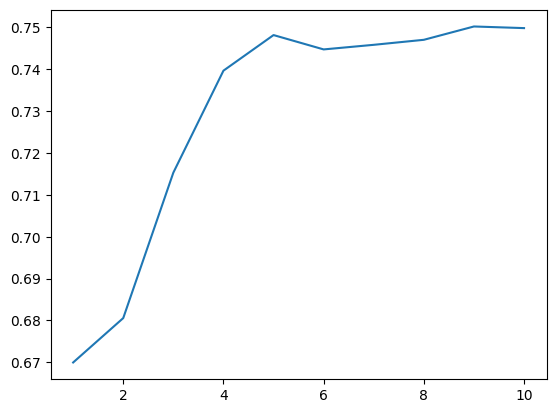

In [56]:
print(vlist)
print(type(vlist))

temp_vlist = []
temp_auclist = []
for var in vlist:
  temp_vlist.append(var)
  print(temp_vlist)
  d_trainTest = xgboost.DMatrix(X_train[temp_vlist], label=y_train)#, feature_names=(variables.remove(p)))
  d_testTest = xgboost.DMatrix(X_test[temp_vlist], label=y_test)#, feature_names=(variables))
  model = xgboost.train(params, d_trainTest, 100, evals = [(d_testTest, "test")], verbose_eval=None, early_stopping_rounds=10, evals_result=results)
  print(max(x for x in results['test']['auc']))
  temp_auclist.append(max(x for x in results['test']['auc']))

plt.plot(np.asarray(range(len(temp_auclist)))+1,temp_auclist)


**Predict on new testing data**

In [83]:
d_train = xgboost.DMatrix(X_train.drop(dropped_vars,axis = 1), label=y_train)#, feature_names=(variables.remove(p)))
d_test = xgboost.DMatrix(X_test.drop(dropped_vars,axis = 1), label=y_test)#, feature_names=(variables))
model = xgboost.train(params, d_train, 100, evals = [(d_test, "test")], verbose_eval=5000, early_stopping_rounds=10, evals_result=results)
print("{:.5f}".format(max(x for x in results['test']['auc'])))

[0]	test-auc:0.71453
[99]	test-auc:0.75014
0.75014


In [84]:
X_test.columns
print(dropped_vars)

['jet 1 phi']


So dropping these variables both sped up our training, as well as marginally increased the AUC Score. This, again, could be optimized if we had more computational resources/time by allowing for a "range" of variables to be excluded. That is, even if the AUC score is within (say) 0.1%, we could drop the variable responsible as its overall effect might be small. Then, retraining the model we could decrease complexity even further while maintaining an acceptable AUC score. 

Finally, lets test our model on our reserved validation set. 

In [112]:
d_test = xgboost.DMatrix(X_test.drop(dropped_vars,axis = 1), label=y_test)
predictions = model.predict(d_test)
cm = metrics.confusion_matrix(y_test, (predictions>0.518))
predict_accuracy_on_test_set = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])*100
print("The Confusion Matrix is")
print(cm)
print (predict_accuracy_on_test_set,'% Is the correction prediction accuracy')

The Confusion Matrix is
[[6089 3333]
 [3065 7513]]
68.01 % Is the correction prediction accuracy


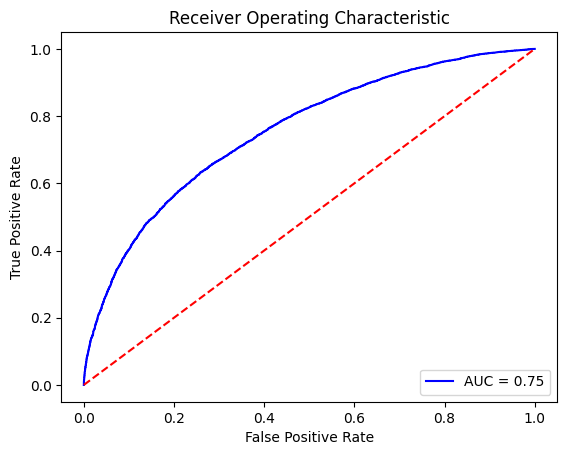

In [91]:
def buildROC(target_test,test_preds):
    fpr, tpr, threshold = metrics.roc_curve(target_test, test_preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

buildROC(y_test,predictions)

### Question

What does the ROC curve tell us? Why is the area under the curve (AUC) used to reference overall performance?